In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime

from sklearn.metrics import mean_squared_error

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics


#### Use weekly median price.

In [2]:
price = pd.read_csv('../data/median_comp_price.csv')

sf_price = price[['date', 'SF_median_price']]
portland_price = price[['date', 'Portland_median_price']]
sf_price.columns = ['ds', 'y']
portland_price.columns = ['ds', 'y']



In [3]:
date_inter = 132
sf_price[:date_inter].head()

,ds,y
0,2015-05-03,NaN
1,2015-05-10,120.0
2,2015-05-17,124.5
3,2015-05-24,125.0
4,2015-05-31,120.0


In [4]:
def forecast(date_inter):

#   Outside Lands 2015: Aug 7 - Aug 9; 
#     2016: Aug 5-7; 
#     2017: Aug 11-13;
#     2018: Aug 10-12;
#     2019: Aug 9-11;

    outside_lands = pd.DataFrame({
     'holiday': 'outside lands',
    'ds': pd.to_datetime(['2019-08-11', '2018-08-12','2017-08-13',
                          '2016-08-07','2015-08-09']),
        'lower_window':0,
        'upper_window':1
    })
    
    
#     dreamforce 2018: Sept 25 - Sept 28
#     dreamforce 2017: Nov 6 - Nov 9
#     dreamforce 2016: Oct 4 - Oct 7
#     dreamforce 2015: Sept 15 - 18

    dreamforce = pd.DataFrame({
        'holiday': 'dreamforce',
        'ds': pd.to_datetime(['2019-11-24','2018-09-30', '2017-11-12', 
                              '2016-10-09', '2015-09-20']),
        'lower_window':0,
        'upper_window':1
    })
    
    holidays = pd.concat((outside_lands, dreamforce))  

    m = Prophet(holidays = holidays, changepoint_prior_scale = 0.1, holidays_prior_scale= 0.5, 
                weekly_seasonality = False, daily_seasonality = False, 
                yearly_seasonality = False)
    
    m.add_seasonality(name = 'month', period= 30.5, fourier_order=5)
    m.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)
    m.add_seasonality(name = 'quarterly', period = 365.25/4, fourier_order =5)
    
    m.add_country_holidays(country_name = 'US')
    
#     take out the first observation with null values.

    m.fit(sf_price[1:date_inter])
    future = m.make_future_dataframe(periods = len(sf_price) - date_inter, freq='W')

    forecast = m.predict(future)
    
    y_true = sf_price.iloc[date_inter:]['y'].values
    y_pred = forecast.iloc[date_inter-1:]['yhat'].values
    rmse = mean_squared_error(y_true, y_pred) **0.5
    rmse = np.round(rmse,2)
    


    fig = m.plot(forecast)
    plt.xlabel('Date')
    plt.ylabel('Price $')
    if date_inter == 132:
        plt.axvline(x = datetime.date(2017,11,5), color = 'k', linestyle='--')
        
        plt.title(f"Forecast for the post-period: cutoff on Nov-5-2017 \n \n RMSE for the Post-Period: {rmse}", fontsize=20)
        
        plt.savefig('../images/sf_forecast_nov2017.png')
        plt.show()
    elif date_inter == 142:
        plt.axvline(x = datetime.date(2018,1,14), color = 'k', linestyle='--')
        plt.title(f"Forecast for the post-period: cutoff on Jan-14-2018 \n \n RMSE for the Post-Period: {rmse}", fontsize=20)
        plt.savefig('../images/sf_forecast_jan2018.png')
        plt.show()
#     a = add_changepoints_to_plot(fig.gca(), m, forecast)
    
#     fig2 = m.plot_components(forecast)

    forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    forecast_df.to_csv('../data/forecast_sf_median_{}.csv'.format(date_inter))
    
    return forecast_df, forecast
    

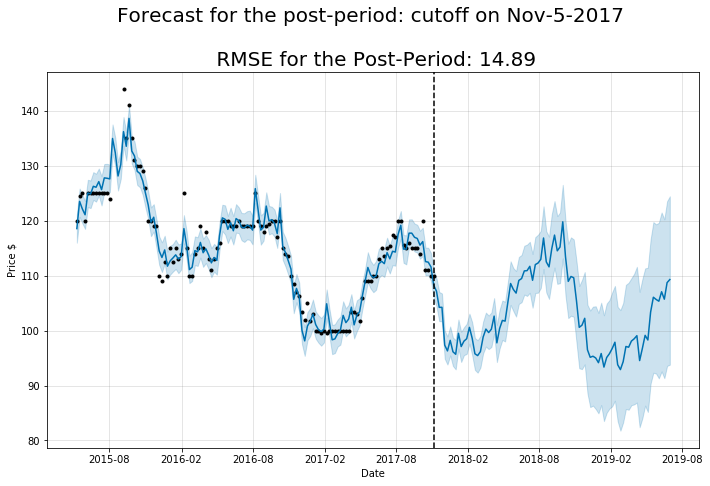

In [5]:
forecast_sf_nov2017, forecast_all_nov2017 = forecast(132)

In [6]:
forecast_sf_nov2017.tail()

,ds,yhat,yhat_lower,yhat_upper
212,2019-06-02,105.358422,91.309384,119.632810
213,2019-06-09,107.080528,92.573025,121.517642
214,2019-06-16,105.724472,91.332142,120.269137
215,2019-06-23,108.741059,93.577502,123.558133
216,2019-06-30,109.300849,93.790595,124.463085


In [7]:
holidays_effect = forecast_all_nov2017[(forecast_all_nov2017['outside lands'] + 
                      forecast_all_nov2017['dreamforce']).abs() >0][['ds','outside lands', 
                        'dreamforce']]

holidays_effect.columns = ['Week', 'Outside Lands', 'Dreamforce']
holidays_effect['Outside Lands'] = holidays_effect['Outside Lands'].round(2)
holidays_effect['Dreamforce'] = holidays_effect['Dreamforce'].round(2)
holidays_effect

,Week,Outside Lands,Dreamforce
13,2015-08-09,2.34,0.00
19,2015-09-20,0.00,5.23
65,2016-08-07,2.34,0.00
74,2016-10-09,0.00,5.23
118,2017-08-13,2.34,0.00
131,2017-11-12,0.00,5.23
170,2018-08-12,2.34,0.00
177,2018-09-30,0.00,5.23


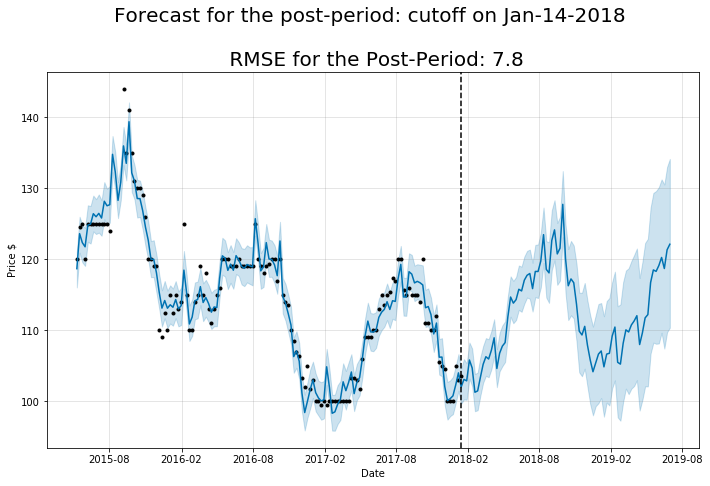

In [8]:
forecast_sf_jan2018, forecast_all_jan2018 = forecast(142)

In [9]:
def forecast_portland(date_inter):
    
    m = Prophet(changepoint_prior_scale = 0.1, holidays_prior_scale= 0.1, 
                weekly_seasonality = False, daily_seasonality = False, 
                yearly_seasonality = False)
    
    m.add_seasonality(name = 'month', period= 30.5, fourier_order=5)
    m.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)
    m.add_seasonality(name = 'quarterly', period = 365.25/4, fourier_order =5)
    
    m.add_country_holidays(country_name = 'US')
    
    m.fit(portland_price[1:date_inter])
    future = m.make_future_dataframe(periods = len(portland_price) - date_inter, freq='W')
    # future['cap'] = 250
    forecast = m.predict(future)

    y_true = portland_price.iloc[date_inter:]['y'].values
    y_pred = forecast.iloc[date_inter-1:]['yhat'].values
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    rmse = np.round(rmse,2)
 
    
    fig = m.plot(forecast)
    plt.xlabel('Date')
    plt.ylabel('Price $')
    if date_inter == 132:
        plt.axvline(x = datetime.date(2017,11,5), color = 'k', linestyle='--')
        plt.title(f"Forecast for the post-period: cutoff on Nov-5-2017 \n \n  RMSE for the Post-Period: {rmse}",fontsize= 20)
    elif date_inter == 142:
        plt.axvline(x = datetime.date(2018,1,16), color = 'k', linestyle='--')
        plt.title(f"Forecast for the post-period: cutoff on Jan-14-2018 \n \n RMSE for the Post-Period: {rmse}",fontsize=20)
#     a = add_changepoints_to_plot(fig.gca(), m, forecast)
    
#     fig2 = m.plot_components(forecast)

    forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    forecast_df.to_csv('../data/forecast_portland_median_{}.csv'.format(date_inter))
    
    

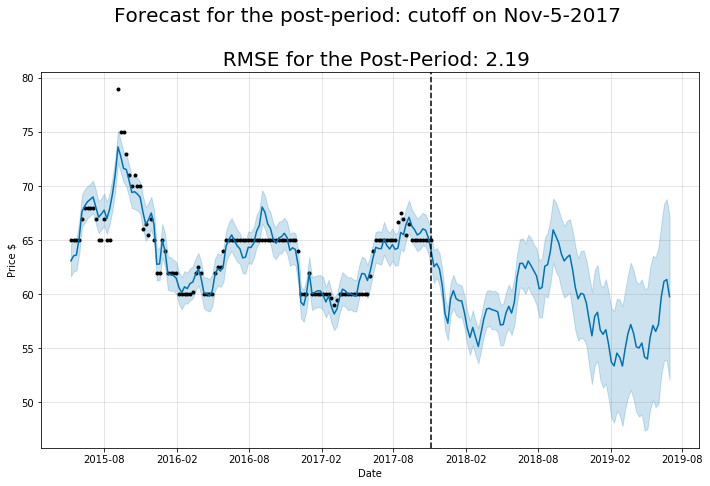

In [10]:
forecast_portland(132)

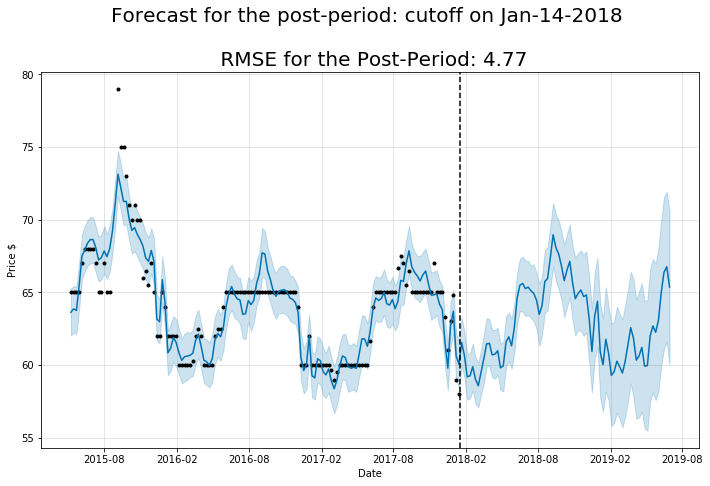

In [11]:
forecast_portland(142)